In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# 設定超參數
num_epochs = 1
batch_size = 32
learning_rate = 0.001
num_classes = 4

# 設定預處理transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 設定訓練資料、驗證資料、測試資料的路徑
train_path = '/home/kevinluo/breast_density_classification/datasets/train'
valid_path = '/home/kevinluo/breast_density_classification/datasets/valid'
test_path = '/home/kevinluo/breast_density_classification/datasets/test'

# 建立資料集與資料載入器
train_dataset = datasets.ImageFolder(train_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 建立模型
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet121', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

# 定義損失函數、優化器、和lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)


Using cache found in /home/kevinluo/.cache/torch/hub/pytorch_vision_v0.9.0


In [6]:
# 訓練模型
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    # 訓練模式
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    # 驗證模式
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)

KeyboardInterrupt: 

In [7]:
import tqdm

train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    # 訓練模式
    model.train()
    with tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Train', unit='batch') as train_bar:
        for i, (inputs, labels) in enumerate(train_bar):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            train_bar.set_postfix({'Loss': loss.item(), 'Acc': torch.sum(preds == labels.data).item()/len(labels)})

    # 驗證模式
    model.eval()
    with torch.no_grad():
        with tqdm.tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Valid', unit='batch') as valid_bar:
            for i, (inputs, labels) in enumerate(valid_bar):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                valid_acc += torch.sum(preds == labels.data)
                valid_bar.set_postfix({'Loss': loss.item(), 'Acc': torch.sum(preds == labels.data).item()/len(labels)})

Epoch 1/1, Valid: 100%|██████████| 10/10 [00:15<00:00,  1.57s/batch, Loss=1.38, Acc=0.545]


In [8]:
# 計算平均損失和精度
train_loss = train_loss / len(train_loader.dataset)
train_acc = train_acc / len(train_loader.dataset)
valid_loss = valid_loss / len(valid_loader.dataset)
valid_acc = valid_acc / len(valid_loader.dataset)

# 更新lr scheduler
scheduler.step(valid_acc)

# 記錄每個epoch的損失和精度
train_loss_history.append(train_loss)
valid_loss_history.append(valid_loss)
train_acc_history.append(train_acc)
valid_acc_history.append(valid_acc)

# 判斷是否更新最佳驗證精度和保存最佳模型
if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    torch.save(model.state_dict(), 'best_model.pth')

# 印出每個epoch的訓練狀況
print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
      f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

Epoch [1/1], Train Loss: 0.8805, Train Acc: 0.6252, Valid Loss: 0.0293, Valid Acc: 0.6355


In [9]:
#載入最佳模型並進行測試
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true += labels.numpy().tolist()
        y_pred += preds.numpy().tolist()

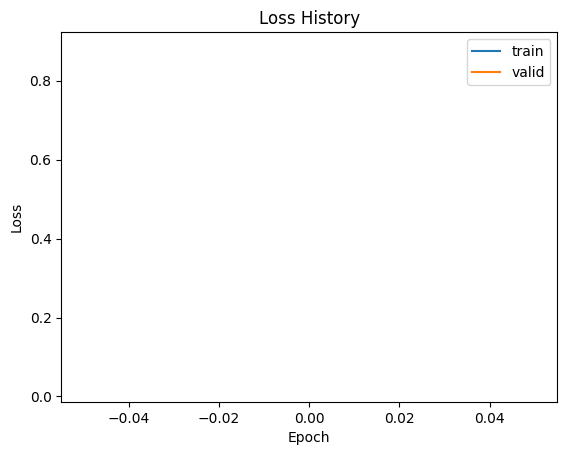

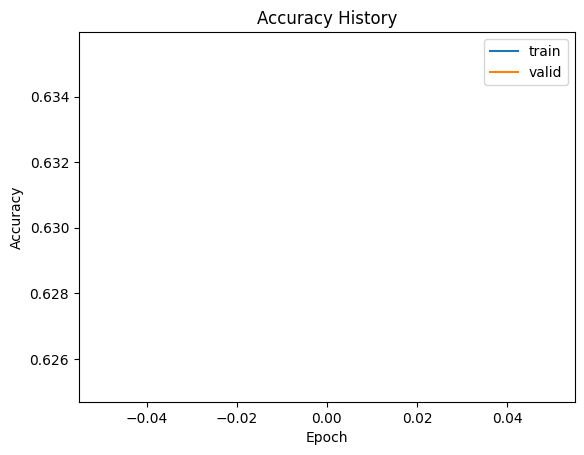

In [11]:
#畫出訓練模型的loss和accuracy變化圖
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history, label='train')
plt.plot(valid_acc_history, label='valid')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

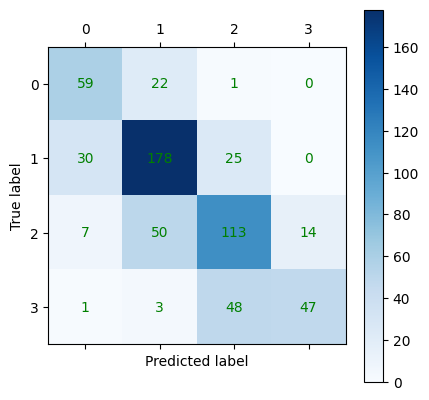

In [14]:
# 計算confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 畫confusion matrix
plt.matshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 在格子上標出數字
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='green')

plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [18]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)



NameError: name 'X_test' is not defined

In [17]:
# 計算每個類別的ROC曲線和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 計算平均ROC AUC
roc_auc_avg = sum(roc_auc.values()) / num_classes

# 畫ROC曲線
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


NameError: name 'y_score' is not defined